### Title: Analyzing The Relationship Between Cryptocurrencies and Inflation

Eshan Kaul
    

We have all heard the countless Bitcoin backers claiming that Bitcoin is a bullet-proof hedge against inflation and is the best way to protect long-term wealth, and recently many established financial institutions have also been hoping onto this bandwagon. Their argument is simple. Bitcoin, unlike normal fiat currencies, has a limited, predetermined supply of coins that can be entered into circulation. This means that governments or central banks can not devalue the currency by increasing the supply. This limited quantity attribute has resulted in many individual and institutional investors liking bitcoin to gold which used to be believed as a hedge against the dollar. 

The goal of this project is to determine if there is any validity to the argument that cryptocurrencies can be used as a hedge against inflation. Are cryptocurrencies really a good method of protecting wealth from inflation and if so, do all cryptocurrencies work, or are specific currencies that work better than others. These questions are motivated by the larger questions of how does adjusting the money supply while maintaining the monetary base affects the greater economy, but for the purposes of this project, we will focus on tackling the more specific questions of what are the relationships between crypto and inflation?

To address this issue we would like to collect relevant data on historical and current inflation rates along with data on the price patterns of at least one type of fixed supply cryptocurrency and one type of cryptocurrency with a flexible supply. 

The analysis will be broken down into two parts. The first part will compare the current/previous relationship between cryptocurrencies and inflation rates. The second part will then be to develop a model to estimate the future trends of cryptocurrencies and inflation rates to explore how the two might vary in the future. 

In [2]:
import pandas as pd
import numpy as np
import requests 
import pandas_datareader as pdr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.formula.api as smf
from bs4 import BeautifulSoup
import time 
import ssl
import json
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

### Reading in Crypto Data

The following data is on the relevant cryptocurrency metrics. These data sets are retrieved from Binance and Coinbase. The Coinbase data is retrieved using a method that is provided by the Coinbase API to retrieve .csv files of their daily data. The method works by passing in a string argument of the cryptocurrency that is being requested and returns the .csv file of the past year's work of data for the specified cryptocurrency. The data that was read in was already cleaned and well named and did not require any additional cleaning scripts to be used for later analysis and visualizations. 

In [5]:
#CRYPTO DATA
filepath = "https://www.cryptodatadownload.com/cdd/Binance_BTCUSDT_d.csv"

# adjusts the setting to account for the HTTPS certificate(s)
ssl._create_default_https_context = ssl._create_unverified_context
# Now we want to create a dataframe and use Pandas' to_csv function to read in our file
Binance_BTC = pd.read_csv(filepath, skiprows = 1)  # use skiprows to drop frist row which contains the url

Coinbase_ETH_dailydata = pd.read_csv("Coinbase_ETHUSD_dailydata.csv")
Coinbase_BTC_dailydata = pd.read_csv("Coinbase_BTCUSD_dailydata.csv")

print(Binance_BTC)
print(Coinbase_BTC_dailydata)
print(Coinbase_ETH_dailydata)

              unix                 date    symbol      open      high  \
0     1.649894e+12  2022-04-14 00:00:00  BTC/USDT  41147.78  41272.19   
1     1.649808e+12  2022-04-13 00:00:00  BTC/USDT  40074.95  41561.31   
2     1.649722e+12  2022-04-12 00:00:00  BTC/USDT  39530.45  40699.00   
3     1.649635e+12  2022-04-11 00:00:00  BTC/USDT  42158.85  42414.71   
4     1.649549e+12  2022-04-10 00:00:00  BTC/USDT  42753.96  43410.30   
...            ...                  ...       ...       ...       ...   
1698  1.503274e+09           2017-08-21  BTC/USDT   4086.29   4119.62   
1699  1.503187e+09           2017-08-20  BTC/USDT   4139.98   4211.08   
1700  1.503101e+09           2017-08-19  BTC/USDT   4108.37   4184.69   
1701  1.503014e+09           2017-08-18  BTC/USDT   4285.08   4371.52   
1702  1.502928e+09           2017-08-17  BTC/USDT   4469.93   4485.39   

           low     close   Volume BTC   Volume USDT  tradecount  
0     41064.35  41233.62    768.36661  3.162933e+07     1

In [3]:
# This method is provided by Coinbase to retrive .csv files of thier daily data from the past year
def fetch_daily_data(symbol):
    pair_split = symbol.split('/')  # symbol must be passed in as the following format "XXX/XXX"  ex."BTC/USD"
    symbol = pair_split[0] + '-' + pair_split[1]
    url = f'https://api.pro.coinbase.com/products/{symbol}/candles?granularity=86400'
    response = requests.get(url)
    if response.status_code == 200:  # checks the response from server is good
        data = pd.DataFrame(json.loads(response.text), columns=['unix', 'low', 'high', 'open', 'close', 'volume'])
        data['date'] = pd.to_datetime(data['unix'], unit='s')  # convert date for readablility
        data['vol_fiat'] = data['volume'] * data['close']      # multiplies crypto volume with closing price to approximate fiat volume                 

        # if data is not recived, print a message to alert no data was returned
        if data is None:
            print("Did not return any data from Coinbase for this symbol")
        # otherwise if data is retrived write to the file
        else:
            data.to_csv(f'Coinbase_{pair_split[0] + pair_split[1]}_dailydata.csv', index=False)

    else:
        print("Did not receieve OK response from Coinbase API")


if __name__ == "__main__":
    # we set which pair we want to retrieve data for
    pair = "BTC/USD"
    fetch_daily_data(symbol=pair)

              

In [8]:
fetch_daily_data("BTC/USD")
fetch_daily_data("ETH/USD")

# Exploratory Analysis

,DATE,CBBTCUSD,CBETHUSD,CBLTCUSD,CBBCHUSD
0,2018-04-12,7916.00,493.41,129.53,737.94
1,2018-04-13,7893.19,495.22,125.46,741.25
2,2018-04-14,8003.11,502.40,126.42,737.17
3,2018-04-15,8355.25,533.74,132.52,779.86
4,2018-04-16,8048.93,511.28,128.63,767.42
...,...,...,...,...,...
1815,2023-04-07,27927.15,1864.71,90.67,124.70
1816,2023-04-08,27959.50,1850.01,90.03,123.77
1817,2023-04-09,28337.04,1858.23,90.61,125.62
1818,2023-04-10,29678.68,1911.04,93.88,128.34


,CBBTCUSD,CBETHUSD,CBLTCUSD,CBBCHUSD
CBBTCUSD,1.000000,0.924715,0.824065,0.298796
CBETHUSD,0.924715,1.000000,0.726175,0.266945
CBLTCUSD,0.824065,0.726175,1.000000,0.683608
CBBCHUSD,0.298796,0.266945,0.683608,1.000000


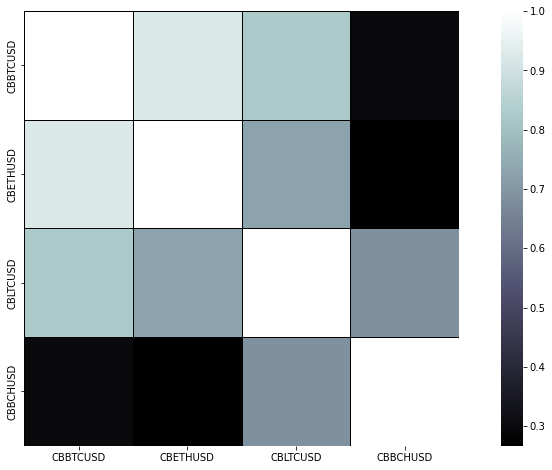

In [5]:
#                                  Bitcoin     Ethereum    Litecoin   Bitcoin Cash
FredCryptoDF = pdr.get_data_fred(["CBBTCUSD", "CBETHUSD", "CBLTCUSD", "CBBCHUSD"])# Reads in crypto data from Federal Reserve Data Base
FredCryptoDF = FredCryptoDF.dropna()
FredCryptoDF = FredCryptoDF.reset_index()
FredCryptoDF = FredCryptoDF.dropna()

display(FredCryptoDF)

plt.figure(figsize = (15,8))
sns.heatmap(FredCryptoDF.corr(), cmap = "bone", linewidths = .7, linecolor = "black", square = True)
FredCryptoDF.corr()



# ARIMA

Although the OLS model is a very powerful tool it is weakened when the model does not follow all seven classical assumptions. The time series model does not specifically address the autocorrelation problem which would likely violate the Gauss-Markov theorem for making the OLS the best unbiased linear estimator. To address this an autoregressive integrated moving average algorithm might be useful in developing an even stronger forecasting algorithm. This model is preferred in time series as it uses the previous values from the time series to predict the future values. In other words, ARIMA models use the lag from their own data and the lag from forecasted errors to predict future values.

The auto regressive **(AR)** part of the model can be described by the follwoing equation: $Y_{t} = {\alpha}+{\beta}_{1}Y_{t-1} + {\beta}_{2}Y_{t-2} + ... + {\beta}_{p}Y_{t-p} + {\epsilon}_{1}$ (2.1)


The moving average **(MA)** part of the model can be described by the follwoing equation: $Y_{t} = {\alpha} + {\epsilon}_{t} +{\phi}_{1}{\epsilon}_{t-1} + {\phi}_{2}{\epsilon}_{t-2} + ... + {\phi}_{q}{\epsilon}_{t-q}$ (2.2)


Combined this yeilds the **(ARIMA)** model: $Y_{t} = {\alpha}+{\beta}_{1}Y_{t-1} + {\beta}_{2}Y_{t-2} + ... + {\beta}_{p}Y_{t-p} + {\epsilon}_{1} + {\phi}_{1}{\epsilon}_{t-1} + {\phi}_{2}{\epsilon}_{t-2} + ... + {\phi}_{q}{\epsilon}_{t-q}$ (2.3)


There are 3 tuning parameters/hyper parameters in the ARIMA model (p, d, q):

- p is the order of the AR term


- d is the number of differences required to make the time series stationary


- q is the order of the MA term

# REVIEW THIS   (GARCH + ROLLING WINDOW)

The ARIMA model as it stands does not take into account the abundance of volitility that affects cryptocurrencies as a whole. To address this we might choose to implement an ARCH/GARCH model in with the ARIMA. 


## ARCH and GARCH models

In this section, we will discuss conditional heteroskedasticity, leading us to our first conditional heteroskedastic model, known as ARCH. Then we will discuss extensions to ARCH, leading us to the famous Generalised Autoregressive Conditional Heteroskedasticity model of order p,q, also known as GARCH(p,q). GARCH is used extensively within the financial industry as many asset prices are conditional heteroskedastic.

$(\epsilon_t)$ | $(\psi_(t-1))$ ~ ${\phi}$
${\displaystyle \epsilon _{t}|\psi _{t-1}\sim {\mathcal {N}}(0,\sigma _{t}^{2})}$

$alt="\rho ={{\sum _{{t=i+1}}^{T}({\hat  \epsilon }_{t}^{2}-{\hat  \sigma }_{t}^{2})({\hat  \epsilon }_{{t-1}}^{2}-{\hat  \sigma }_{{t-1}}^{2})} \over {\sum _{{t=1}}^{T}({\hat  \epsilon }_{t}^{2}-{\hat  \sigma }_{t}^{2})^{2}}}$


${\displaystyle \sigma _{t}^{2}=\omega +\alpha _{1}\epsilon _{t-1}^{2}+\cdots +\alpha _{q}\epsilon _{t-q}^{2}+\beta _{1}\sigma _{t-1}^{2}+\cdots +\beta _{p}\sigma _{t-p}^{2}=\omega +\sum _{i=1}^{q}\alpha _{i}\epsilon _{t-i}^{2}+\sum _{i=1}^{p}\beta _{i}\sigma _{t-i}^{2}}$

### Conditional Heteroskedasticity

The main motivation for studying conditional heteroskedasticity in finance is that of volatility of asset returns. A collection of random variables is heteroskedastic if there are certain groups, or subsets, of variables within the larger set that have a different variance from the remaining variables.

# read
In finance, an increase in variance maybe correlated to a further increase in variance. For instance, on a day that equities markets undergo a substantial drop, automated risk management sell orders in long only portfolios get triggered, which lead to further fall in the price of equities within these portfolios, leading to significant downward volatility.

These "sell-off" periods, as well as many other forms of volatility, lead to heteroskedasticity that is serially correlated and hence conditional on periods of increased variance. Thus we say that such series are conditional heteroskedastic.

One of the challenging aspects of conditional heteroskedastic series is ACF plots of a series with volatility might still appear to be a realisation of stationary discrete white noise. This is despite the fact that the series is most definitely non-stationary as its variance is not constant in time.
To incorporate CH in our model, we can create a model that utilises an autoregressive process for the variance itself - a model that actually accounts for the changes in the variance over time using past values of the variance.
This is the basis of the Autoregressive Conditional Heteroskedastic (ARCH) model.
Autoregressive Conditionally Heteroskedastic Models - ARCH(p)

ARCH(p) models can be thought of as simply an AR(p) model applied to the variance of a time series.
$$Var(\epsilon_t) = \alpha_0 + \alpha_1Var(\epsilon_{t-1})+…+\alpha_pVar(\epsilon_{t-p})+w_t$$
The actual time series is given by:
$$\epsilon_t = w_t\sqrt{\alpha_0 + \alpha_1\epsilon_{t-1}^2+…+\alpha_p\epsilon_{t-p}^2}$$
For ARCH(1), this reads: $$\epsilon_t = w_t\sqrt{\alpha_0+\alpha_1\epsilon_{t-1}^2}$$

When To Apply ARCH(p)?

When we were attempting to fit an AR(p) model and are concerned with the decay of the $p$ lag on a ACF plot of the series, we can apply the same logic to the square of the residuals. If we find that we can apply an AR(p) to these square residuals then we have an indication that an ARCH(p) process may be appropriate.
Note that ARCH(p) should only ever be applied to a series that has already had an appropriate model fitted sufficient to leave the residuals looking like discrete white noise. Since we can only tell whether ARCH is appropriate or not by squaring the residuals and examining the ACF, we also need to ensure that the mean of the residuals is zero.
ARCH should only ever be applied to series that do not have any trends or seasonal effects, i.e. that has no (evident) serially correlation. ARIMA is often applied to such a series, at which point ARCH may be a good fit.


# Rolling Window

Additionally, we might choose to further tune the models hyper parameters using a rolling window. 

### Rolling Window Statistics

A step beyond adding raw lagged values is to add a summary of the values at previous time steps. We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous values, also called the rolling mean.

## Stationary VS Non-Stationary

The first step is to calculate the number of differencing operations required to make the time series data stationary. This will be done using the Augmented Dicky Fuller Test(ADF). 

Let $H_{0}: $ $d { \neq } 0$ in other words, the time series is non-stationary 
Then it follows that $H_{{\alpha}}: $ $d = 0$ in other words, the time series is stationary 

This test will reject the null if p-value < 0.05 in which case there is no need to find an order of differencing. If the p-value is > 0.05 then we would fail to reject the null and the series will require differencing operations to be performed until the time series is stationary. 

In [10]:
# method to test if the time series data is stationary
def ADF_Test(data):
    adf_test = adfuller(data, autolag = "AIC")
    print(f"ADF: {adf_test[0]}")
    print(f"p-value: {adf_test[1]}")
    print(f"Number of Lag: {adf_test[2]}")
    print(f"Number of Observations: {adf_test[3]}")
    print(f"Critical Values:")
    for percent, item in adf_test[4].items():
        print("\t", percent, ": ", item)
        
ADF_Test(FredCryptoDF.CBBCHUSD)
ADF_Test(FredCryptoDF.CBETHUSD)


ADF: -5.025929538170148
p-value: 1.9714877310381783e-05
Number of Lag: 25
Number of Observations: 1794
Critical Values:
	 1% :  -3.4340003240943844
	 5% :  -2.8631524150111547
	 10% :  -2.567628397867784
ADF: -1.2203817210659915
p-value: 0.664767136977887
Number of Lag: 19
Number of Observations: 1800
Critical Values:
	 1% :  -3.4339881389288407
	 5% :  -2.863147035877915
	 10% :  -2.567625533641975


### Interpreting ADF-Test Results

Note that the p-values for the first 3 cryptocurrencies are all very high, above 0.05. Additionally, the majority of the critical values are less than the values of their respective Augmented Dicky Fuller test statistic. As a result, we cannot reject the null hypothesis, which leaves us to conclude that the time series data is not stationary. 

Intuitively, this makes sense in the context of cryptocurrencies prices and expected inflation rates. This is because changes in crypto prices and inflation expectations are generally speaking the result of mean independent increments that occur to daily economic shocks. These movements in prices depend on the previous price. One method of dealing with this issue is to model the returns of the crypto prices instead of the prices. While daily prices $X_{t}$ are generally non stationary while the daily returns $Y_{t} = \frac{X_{t} - X_{t-1}}{X_{t-1}}$ are generally stationary. To confirm the assumption that price movements are non-stationary we can look at the generalized daily price movements function. $X_{t} = X_{t-1} + {\epsilon}_{t} = X_{t-2} + {\epsilon}_{t-1} + {\epsilon}_{t} + X_{t-3} + {\epsilon}_{t-2} + {\epsilon}_{t} + ... + $ by repeated substitution yeilds: $\sum_{{\tau}=0}^{t} {\epsilon_{\tau}}$ which by definition is a linear stochastic process that has a unit root of 1 which describes a non stationary process. While taking the percent change is a good method to remove this effect another method is to take the log difference of the function. Applying the log difference to the function is useful as logarithms are time-invariant and will help to stabilize the variance. Taking the first order of difference of this function can be used to obtain the required stationary data. 

Since the initial ordinary least squares regression model showed that Bitcoin and Ethereum are most likely to have a strong correlation with the expected inflation rates, we will focus our efforts on making those data sets stationery

## Making Timeseries Data Stationary 

D is the number of differences required to make the time series stationary. This will be done by ploting the Autocorrelation Function (ACF) and performing the order of difference operation on the data untill the data becomes stationary. 

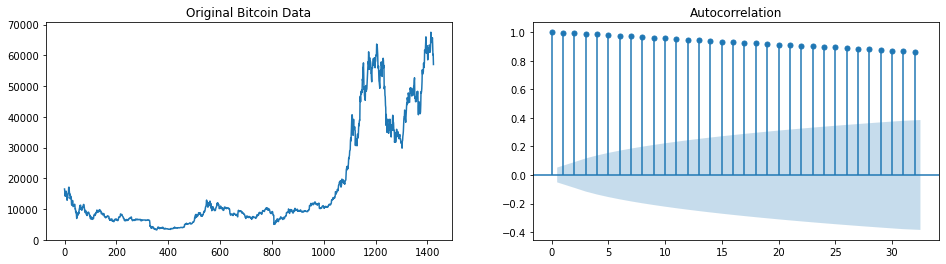

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(FredCryptoDF.CBBTCUSD)
ax1.set_title("Original Bitcoin Data")
plot_acf(FredCryptoDF.CBBTCUSD, ax = ax2);



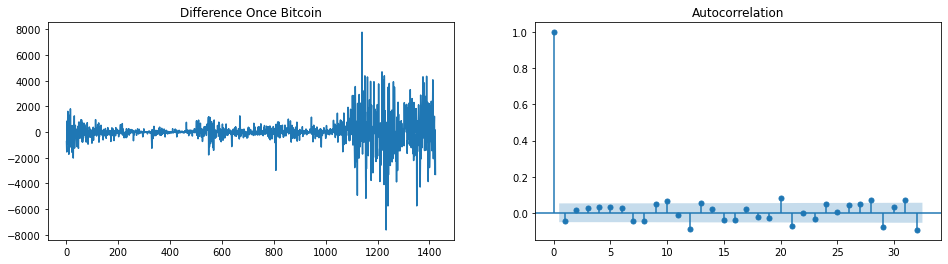

In [23]:
diff = FredCryptoDF.CBBTCUSD.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 4))

ax1.plot(diff)
ax1.set_title("Difference Once Bitcoin")
plot_acf(diff, ax = ax2);

### Interpreting the Bitcoin Timeseries Data
In the first plot, we can see that there is clear movement of the Bitcoin closing prices over time. Additionally, we see severe autocorrelation for the initial data. The second plot shows the first-order difference of the Bitcoin data. Here we can instantly see that the data is much more stationary than before and the autocorrelation is for the most part in an acceptable range. From these graphs, we can conclude that the value of d, the order of differences required to make the time series stationary in the ARIMA model, is 1 for the first-order difference of the Bitcoin data. 

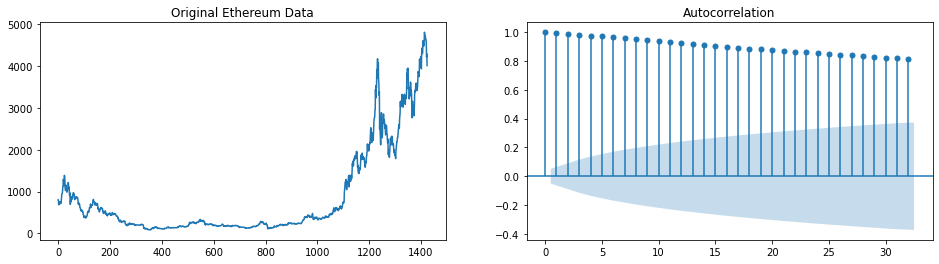

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(FredCryptoDF.CBETHUSD)
ax1.set_title("Original Ethereum Data")
plot_acf(FredCryptoDF.CBETHUSD, ax = ax2);

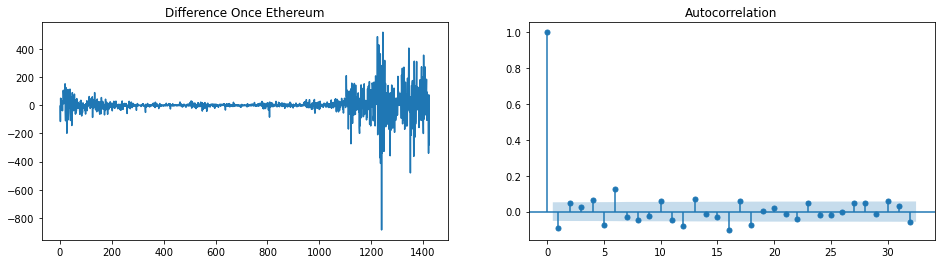

In [25]:
diff = FredCryptoDF.CBETHUSD.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 4))

ax1.plot(diff)
ax1.set_title("Difference Once Ethereum")
plot_acf(diff, ax = ax2);

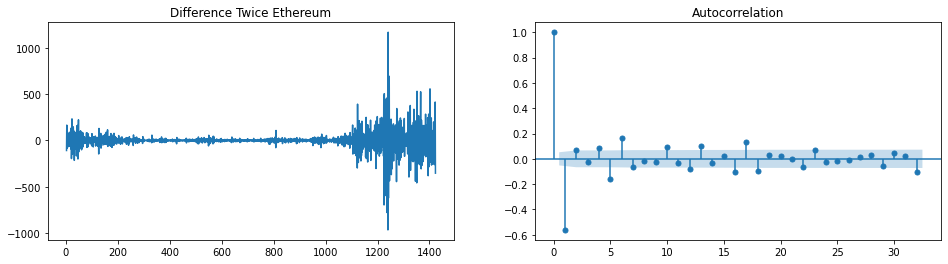

In [26]:
diff = FredCryptoDF.CBETHUSD.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 4))

ax1.plot(diff)
ax1.set_title("Difference Twice Ethereum")
plot_acf(diff, ax = ax2);


### Interpreting the Timeseries Ethereum Data
In the first plot, we can see that the Ethereum closing prices are clearly moving in an upwards direction over time and is thus non-stationary. Additionally, we see severe autocorrelation for the initial data. The second plot shows the first-order difference of the Ethereum data. Here the data is much more stationary than before and the autocorrelation is less severe. The third plot shows the second-order difference for the Ethereum data. When compared with the first-order difference we see that the first-order difference is a better fit. From these graphs, we can conclude that the value of d should be 1 for the first-order difference of the Ethereum data.

## Determining P (Auto Regressive Term)
P is the number of lags to be used in the ARIMA model. This can be determined by creating a Partial Autocorrelation Plot (PACF Plot). Here the partial autocorrelation represents the correlation between the time-series data and its lags. 

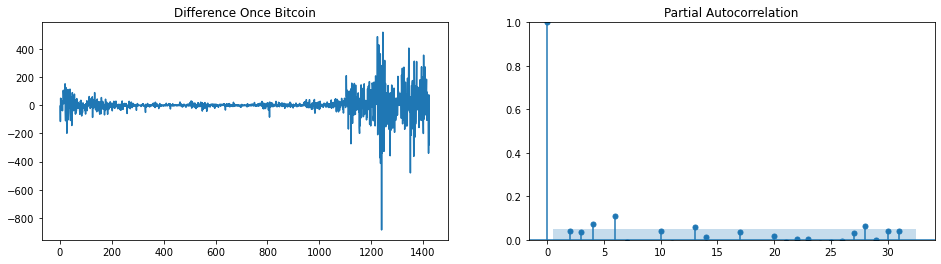

In [27]:
diff = FredCryptoDF.CBETHUSD.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 4))

ax1.plot(diff)
ax1.set_title("Difference Once Bitcoin")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax = ax2);

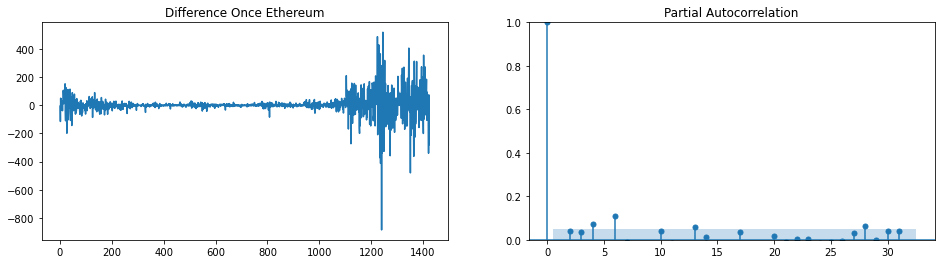

In [28]:
diff = FredCryptoDF.CBETHUSD.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 4))

ax1.plot(diff)
ax1.set_title("Difference Once Ethereum")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax = ax2);

### Interperting Autoregressive Term
From both PACF plots it is clear that the first term in the data that displays significant lag is point 6. Thus the q value for the AMIRA model for both Bitcoin and Ethereum is 6. 

## Determining Q (Moving Average Term)
Q is the order of the moving average term to be used in the ARIMA model. This refers to the number of lagged forecast errors that should be taken into account in the model. The ACF plot will show the number of lags to consider.

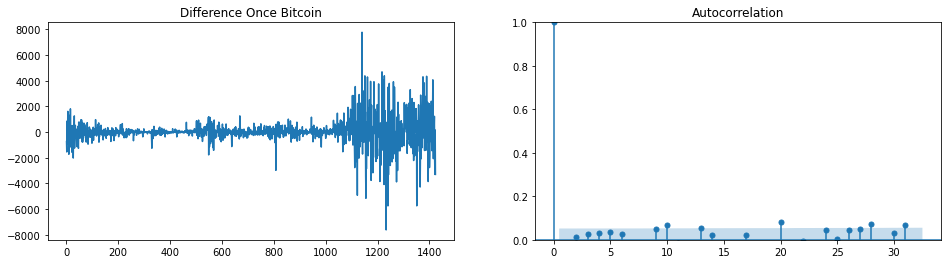

In [29]:
diff = FredCryptoDF.CBBTCUSD.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 4))

ax1.plot(diff)
ax2.set_ylim(0, 1)
ax1.set_title("Difference Once Bitcoin")
plot_acf(diff, ax = ax2);

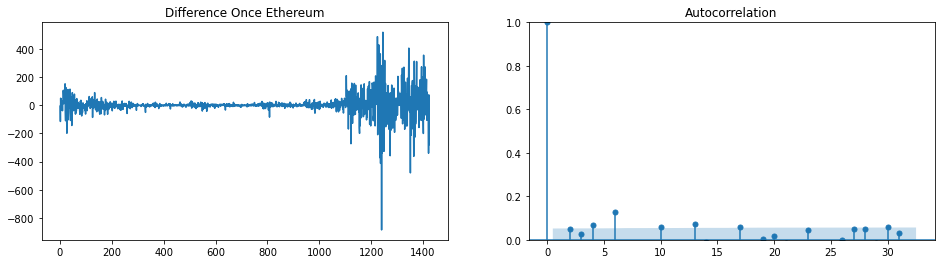

In [30]:
diff = FredCryptoDF.CBETHUSD.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 4))

ax1.plot(diff)
ax1.set_title("Difference Once Ethereum")
ax2.set_ylim(0, 1)
plot_acf(diff, ax = ax2);

### Interperting Moving Average Term
From the plots above, we can determine that number of lagged forecast errors for Bitcoin is 4 and the number of errors for Ethereum is 3. 

## Fitting the ARIMA Model For Bitcoin and Ethereum

### Bitcoin ARIMA Price Forecast

In [31]:
model = ARIMA(FredCryptoDF.CBBTCUSD, order = (6,1,4)) #ARIMA model for Bitcoin
result_BTC = model.fit(disp = 0)
print(result_BTC.summary())

/Users/eshankaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




                             ARIMA Model Results                              
Dep. Variable:             D.CBBTCUSD   No. Observations:                 1423
Model:                 ARIMA(6, 1, 4)   Log Likelihood              -11793.207
Method:                       css-mle   S.D. of innovations            961.064
Date:                Mon, 07 Mar 2022   AIC                          23610.415
Time:                        18:21:11   BIC                          23673.541
Sample:                             1   HQIC                         23633.993
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               27.6949     27.141      1.020      0.308     -25.501      80.891
ar.L1.D.CBBTCUSD     0.0468      0.099      0.471      0.637      -0.148       0.242
ar.L2.D.CBBTCUSD    -1.4398 

The model above shows the results from the ARIMA model on the Bitcoin data. The plots below show that the data is indeed stationary, and the data is distributed around the mean which confirms the stationary nature of the data. 

(array([1.48281335e-06, 2.47135559e-06, 7.90833789e-06, 3.41047071e-05,
        5.17007589e-04, 1.13682357e-04, 1.87823025e-05, 7.41406677e-06,
        0.00000000e+00, 4.94271118e-07]),
 array([-6801.31129456, -5379.53959234, -3957.76789012, -2535.9961879 ,
        -1114.22448568,   307.54721654,  1729.31891876,  3151.09062098,
         4572.8623232 ,  5994.63402542,  7416.40572764]),
 <BarContainer object of 10 artists>)

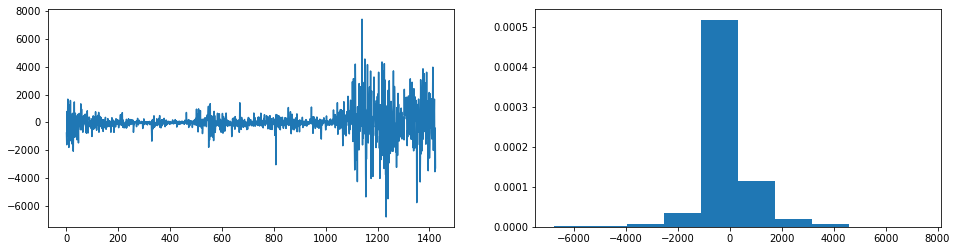

In [32]:
residuals_BTC = pd.DataFrame(result_BTC.resid)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 4))
ax1.plot(residuals_BTC)
ax2.hist(residuals_BTC, density = True)


### Plot Bitcoin Price Forcast
Based on the results from the Bitcoin ARIMA model we can now plot the forecasted model against the actual closing price movements. The ARIMA model shows a much greater fit then the original OLS model that was used before. 

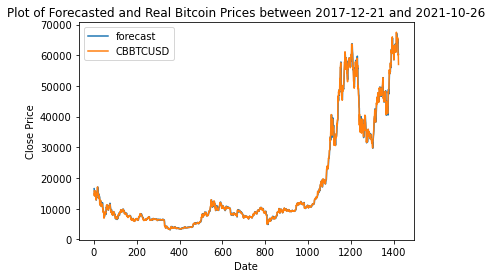

date 1 is: 2017-12-21 00:00:00
date 200 is: 2018-07-08 00:00:00
date 400 is: 2019-01-29 00:00:00
date 600 is: 2019-08-17 00:00:00
date 800 is: 2020-03-04 00:00:00
date 1000 is: 2020-09-21 00:00:00
date 1200 is: 2021-04-09 00:00:00
date 1400 is: 2021-10-26 00:00:00


In [33]:
fig = result_BTC.plot_predict(start = 1, end = 1423, dynamic = False);
plt.title("Plot of Forecasted and Real Bitcoin Prices between 2017-12-21 and 2021-10-26")
plt.xlabel("Date") # 1 = 2017-12-21   200 = 2019-01-29  800 = 2020-03-04   1200 = 2021-04-09   1400 = 2021-10-26
plt.ylabel("Close Price")
plt.show()
print(f"date 1 is: {FredCryptoDF.DATE[1]}")
print(f"date 200 is: {FredCryptoDF.DATE[200]}")
print(f"date 400 is: {FredCryptoDF.DATE[400]}")
print(f"date 600 is: {FredCryptoDF.DATE[600]}")
print(f"date 800 is: {FredCryptoDF.DATE[800]}")
print(f"date 1000 is: {FredCryptoDF.DATE[1000]}")
print(f"date 1200 is: {FredCryptoDF.DATE[1200]}")
print(f"date 1400 is: {FredCryptoDF.DATE[1400]}")

### Ethereum ARIMA Price Forecast

In [34]:
model = ARIMA(FredCryptoDF.CBETHUSD, order = (6,1,3)) #ARIMA model for Ethereum
result_ETH = model.fit(disp = 0)
print(result_ETH.summary())

/Users/eshankaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




                             ARIMA Model Results                              
Dep. Variable:             D.CBETHUSD   No. Observations:                 1423
Model:                 ARIMA(6, 1, 3)   Log Likelihood               -8080.999
Method:                       css-mle   S.D. of innovations             70.795
Date:                Mon, 07 Mar 2022   AIC                          16183.999
Time:                        18:21:15   BIC                          16241.864
Sample:                             1   HQIC                         16205.613
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.2005      2.035      1.081      0.279      -1.788       6.189
ar.L1.D.CBETHUSD    -0.4681      0.196     -2.385      0.017      -0.853      -0.083
ar.L2.D.CBETHUSD    -0.8034 

(array([5.50379803e-06, 0.00000000e+00, 5.50379803e-06, 3.85265862e-05,
        1.21083557e-04, 8.64096291e-04, 6.38990952e-03, 3.24724084e-04,
        5.50379803e-05, 2.75189902e-05]),
 array([-794.24171143, -666.55884872, -538.875986  , -411.19312329,
        -283.51026058, -155.82739787,  -28.14453516,   99.53832755,
         227.22119026,  354.90405297,  482.58691568]),
 <BarContainer object of 10 artists>)

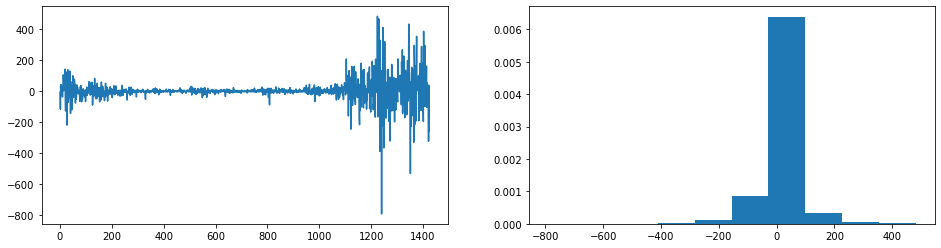

In [35]:
residuals_ETH = pd.DataFrame(result_ETH.resid)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 4))
ax1.plot(residuals_ETH)
ax2.hist(residuals_ETH, density = True)

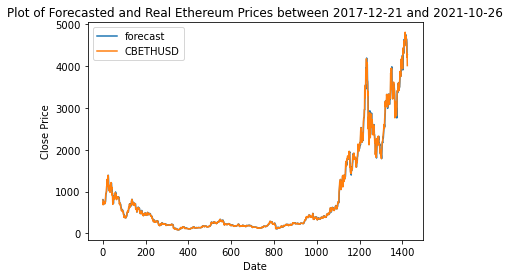

date 1 is: 2017-12-21 00:00:00
date 200 is: 2018-07-08 00:00:00
date 400 is: 2019-01-29 00:00:00
date 600 is: 2019-08-17 00:00:00
date 800 is: 2020-03-04 00:00:00
date 1000 is: 2020-09-21 00:00:00
date 1200 is: 2021-04-09 00:00:00
date 1400 is: 2021-10-26 00:00:00


In [36]:
fig = result_ETH.plot_predict(start = 1, end = 1423, dynamic = False);
plt.title("Plot of Forecasted and Real Ethereum Prices between 2017-12-21 and 2021-10-26")
plt.xlabel("Date") # 1 = 2017-12-21   200 = 2019-01-29  800 = 2020-03-04   1200 = 2021-04-09   1400 = 2021-10-26
plt.ylabel("Close Price")
plt.show()
print(f"date 1 is: {FredCryptoDF.DATE[1]}")
print(f"date 200 is: {FredCryptoDF.DATE[200]}")
print(f"date 400 is: {FredCryptoDF.DATE[400]}")
print(f"date 600 is: {FredCryptoDF.DATE[600]}")
print(f"date 800 is: {FredCryptoDF.DATE[800]}")
print(f"date 1000 is: {FredCryptoDF.DATE[1000]}")
print(f"date 1200 is: {FredCryptoDF.DATE[1200]}")
print(f"date 1400 is: {FredCryptoDF.DATE[1400]}")

### Plot Ethereum Price Forcast
Based on the results from the Ethereum ARIMA model we can now plot the forecasted model against the actual closing price movements. From this visual, we can observe that the ARIMA model is a good fit for the real Ethereum data over this time period. This type of model might be useful to crypto investors in making their predictions on how the price of the cryptocurrency will move over time to optimize their strategy. 

To predict the next n samples of Ethereum prices we can use the .forcast(steps = n) method which will return an array of the next n predictions of Ethereum closing prices based off the ARIMA model.

In [37]:
result_ETH.forecast(steps = 100)[0]

array([4012.58716569, 3984.57695835, 4000.73647768, 3942.67926619,
       3977.9744621 , 3963.91218661, 3962.76432084, 3961.5560706 ,
       3976.66869338, 3965.92534116, 3969.24644909, 3975.38876529,
       3978.61435399, 3975.28329434, 3980.2737222 , 3983.76244813,
       3984.74690392, 3985.90884531, 3989.63316421, 3991.54398744,
       3993.2296392 , 3995.6282382 , 3998.16637848, 4000.00033205,
       4002.23632275, 4004.60348936, 4006.73989457, 4008.82704204,
       4011.14397496, 4013.35623583, 4015.48583321, 4017.6965671 ,
       4019.94654209, 4022.11747705, 4024.30097418, 4026.52351164,
       4028.72835205, 4030.91248043, 4033.11765396, 4035.32551505,
       4037.52078629, 4039.71863311, 4041.92382161, 4044.1237866 ,
       4046.32174943, 4048.52362797, 4050.72531593, 4052.92439754,
       4055.12480452, 4057.32627946, 4059.52652459, 4061.72652387,
       4063.92744205, 4066.12813482, 4068.32835116, 4070.52888108,
       4072.72959644, 4074.93003662, 4077.13047565, 4079.33108

https://quant.stackexchange.com/questions/16481/why-do-we-usually-model-returns-and-not-prices
https://quant.stackexchange.com/questions/4160/discrete-returns-versus-log-returns-of-assets
https://www.emerald.com/insight/content/doi/10.1108/SEF-09-2012-0106/full/html
https://stats.stackexchange.com/questions/465514/why-prices-are-usually-not-stationary-but-returns-are-more-likely-to-be-station
https://en.wikipedia.org/wiki/Unit_root
https://otexts.com/fpp2/stationarity.html
https://blog.quantinsti.com/stationarity/
https://link.springer.com/article/10.1007/s00521-020-05129-6
https://www.semanticscholar.org/paper/Time-series-forecast-in-non-stationary-environment-Garbacz/f79fb84f5001dafe120c68ae7379f92907566511
https://www.semanticscholar.org/paper/Time-series-forecast-in-non-stationary-environment-Garbacz/f79fb84f5001dafe120c68ae7379f92907566511

https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
https://en.wikipedia.org/wiki/Ordinary_least_squares
https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average